# Debugging HIP applications

There is an almost infinite number of ways that software can mess up. Thankfully in HIP there is ample support for debugging programs using the underlying platform's debugging tools. On AMD the debugging tool is [rocgdb](https://github.com/ROCm-Developer-Tools/ROCgdb), and on CUDA it is [cuda-gdb](https://developer.nvidia.com/cuda-gdb). Using the following techniques we can squash a majority of bugs in HIP programs:

* Checking the return codes on every HIP function call.
* Checking inputs, outputs and memory handling before checking kernels.
* Using **printf** within kernels.
* Using **Rocgdb** to check memory access violations.

## Buggy matrix multiplication

We introduce an **bug** into our matrix multiplication kernel and see what techniques can uncover the error. In this instance we **intentionally remove** the guard check that protects the kernel from setting values outside the domain of **C**. The size of matrices **A**, **B**, and **C** are set to (72,72) with a block size of (16,4,1). In the kernel we say that dimension 0 of the grid maps to dimension 1 of the matrices because we have chosen row-major ordering and dimension 1 of the matrices is the contiguous (fastest) dimension. Similarly, in the kernel we say that dimension 1 of the grid maps to dimension 0 of the matrices.

Since an integer number of blocks must compose the grid, it must then be of size $(80,72,1)$, which is a multiple of the block size (16,4,1) and is the smallest size that will cover the matrices. This grid is then mapped to a size of (72,80) as shown in the diagram below.

<figure style="margin-left:auto; margin-right:auto; width:80%;">
    <img style="vertical-align:middle" src="../images/matrix_boundaries.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Running off the end of the array due to differences between array size and global size.</figcaption>
</figure>

If we do not have a guard in place, then array accesses into the matrices will run off the ends, resulting in a memory access violation. We remove the guard in the kernel section of [mat_mult_badmem.cpp](mat_mult_badmem.cpp), as shown below:

```C++
// mat_mult_badmem.cpp source

// standard matrix multiply kernel without a guard check
__global__ void mat_mult (
        float* A, 
        float* B, 
        float* C, 
        size_t N1_A, 
        size_t N0_C,
        size_t N1_C) { 
            
    // C is of size (N0_C, N1_C)
    
    // i0 and i1 represent the coordinates in Matrix C 
    // We assume row-major ordering for the matrices
    size_t i0 = blockIdx.y * blockDim.y + threadIdx.y;
    size_t i1 = blockIdx.x * blockDim.x + threadIdx.x;
    
    // Scratch variable
    float temp=0.0; 

    // Guard mechanism to make sure we do not go
    // outside the boundaries of matrix C 
    //if ((i0<N0_C) && (i1<N1_C)) {
        // Loop over columns of A and rows of B 
        for (size_t n=0; n<N1_A; n++) {
            
            // A is of size (N0_C, N1_A)
            // B is of size (N1_A, N1_C)
            
            // Loop across row i0 of A
            // and down column i1 of B
            temp+=A[i0*N1_A+n]*B[n*N1_C+i1]; 
        } 
        // Number of rows in C is same as number of rows in A
        C[i0*N1_C+i1]=temp;
    //}
} 
```

## Run the buggy application

If we try running this code then the maximum residual is (sometimes much) larger than expected.

In [14]:
!make clean; make; ./mat_mult_badmem.exe

rm -r *.exe
hipcc -g -O2 -fopenmp -ggdb -I/usr/include -I../include -L/usr/lib/x86_64-linux-gnu mat_mult.cpp\
	-o mat_mult.exe 
hipcc -g -O2 -fopenmp -ggdb -I/usr/include -I../include -L/usr/lib/x86_64-linux-gnu mat_mult_badmem.cpp\
	-o mat_mult_badmem.exe 
Device id: 0
	name:                                    
	global memory size:                      536 MB
	available registers per block:           65536 
	maximum shared memory size per block:    65 KB
	maximum pitch size for memory copies:    536 MB
	max block size:                          (1024,1024,1024)
	max threads in a block:                  1024
	max Grid size:                           (2147483647,2147483647,2147483647)
Maximum error (infinity norm) is: 1.67919e+38


Notice that with this HIP implementation the code completes without crashing, even though we know there is a memory access violation. Some HIP implementations (GPU ones in particular) do not have strict memory access violation checks. Memory access violations can result in undefined behaviour. Due to OS security, CPU implementations are more sensitive to memory access violations than GPU implementations, where memory allocations may be padded and memory access violations are not as protected.

## Visual inspection of outputs

We load the files **array_A.dat**, **array_B.dat**, and **array_C.dat** into memory and compare results.

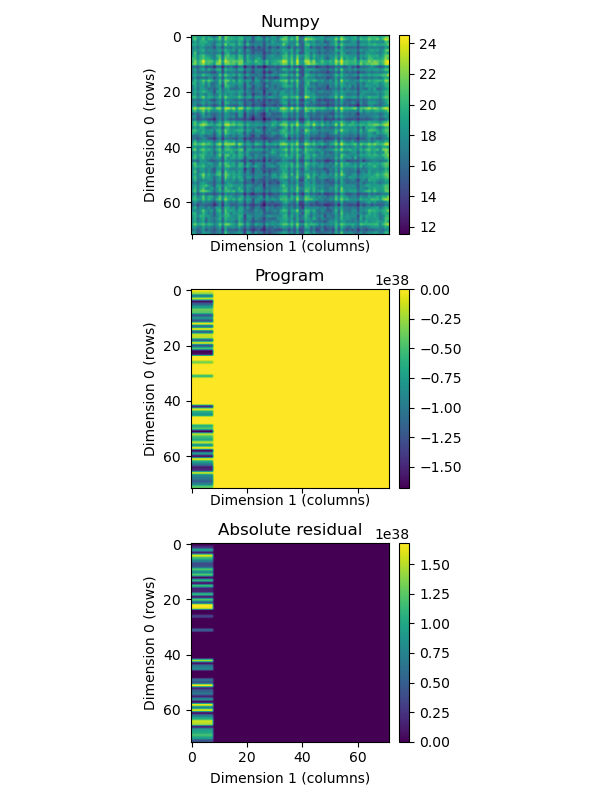

In [18]:
import os
import sys
import numpy as np
sys.path.insert(0, os.path.abspath("../include"))

import py_helper

%matplotlib widget

# Data type to use for matrices
dtype=np.float32

defines=py_helper.load_defines("mat_size.hpp")

NCOLS_A=defines["NCOLS_A"]
NROWS_C=defines["NROWS_C"]
NCOLS_C=defines["NCOLS_C"]

# A is of size (NROWS_C, NCOLS_A)
# B is of size (NCOLS_A, NCOLS_C)    
# C is of size (NROWS_C, NCOLS_C)

mat_mul=py_helper.MatMul(NCOLS_A, NROWS_C, NCOLS_C, dtype)
mat_mul.load_data()
mat_mul.check_data()

The effect of the memory error is noticeable when we perform a direct comparison between Python and our OpenCL application. Row 0 of the of the output is unaffected, however all subsequent rows are affected by the bug because for each row the kernel spills over to 8 cells of the next row. Often the numbers in the output are nonsense because we have gone outside the bounds of matrices A (and especially) B for the read, and off the bounds of matrix C for the last line of the write.

## Checking HIP calls 

Inspecting the return codes of OpenCL calls is good practice for programming with OpenCL. Many API errors are caught this way. In this lesson we have already checked return codes and they haven't signalled an error. We need to dig deeper....

## Checking memory access by filling with known values

When trying to get your OpenCL codes working it is helpful to first make sure that your memory accesses are valid. In this instance we change the kernel so that it fills **C** with a **known value**. In this case we fill it with **i1** as shown in the kernel from [mat_mult_memcheck.cpp](mat_mult_memcheck.cpp). Run the code and check the results by running the visual check above.

```C++
__global__ void mat_mult (
        float* A, 
        float* B, 
        float* C, 
        size_t N1_A, 
        size_t N0_C,
        size_t N1_C) { 
            
    // C is of size (N0_C, N1_C)
    
    // i0 and i1 represent the coordinates in Matrix C 
    // We assume row-major ordering for the matrices
    size_t i0 = blockIdx.y * blockDim.y + threadIdx.y;
    size_t i1 = blockIdx.x * blockDim.x + threadIdx.x;
    
    // Scratch variable
    float temp=0.0; 

    // Guard mechanism to make sure we do not go
    // outside the boundaries of matrix C 
    //if ((i0<N0_C) && (i1<N1_C)) {
        // Loop over columns of A and rows of B 
        for (size_t n=0; n<N1_A; n++) {
            
            // A is of size (N0_C, N1_A)
            // B is of size (N1_A, N1_C)
            
            // Loop across row i0 of A
            // and down column i1 of B
            temp+=A[i0*N1_A+n]*B[n*N1_C+i1]; 
        } 
        // Number of rows in C is same as number of rows in A
        C[i0*N1_C+i1]=(float)i1;
    //}
}
```


In [25]:
!make; ./mat_mult_memcheck.exe

make: Nothing to be done for 'all'.
Device id: 0
	name:                                    
	global memory size:                      536 MB
	available registers per block:           65536 
	maximum shared memory size per block:    65 KB
	maximum pitch size for memory copies:    536 MB
	max block size:                          (1024,1024,1024)
	max threads in a block:                  1024
	max Grid size:                           (2147483647,2147483647,2147483647)
Maximum error (infinity norm) is: 65.5778


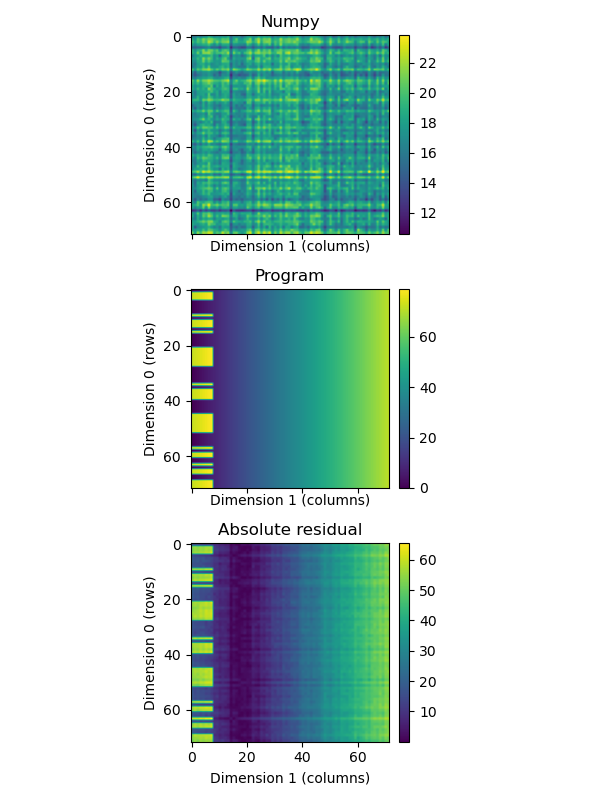

In [26]:
mat_mul.load_data()
mat_mul.check_data()

In the visual check some lines are filled with higher values of **i1** whereas others are filled with lower values. This is because in the buggy implementation two different kernel invocations are writing to the **same global memory location**. Also note that values have stabilised becuase the kernel ignores the reads from memory. This illustrates that one cannot rely on the order in which workgroups complete and the order in which memory updates are flushed back to global memory. Checking your memory inputs and outputs using **known** values in the kernel is a powerful **first pass** technique for debugging. It is good practice to make sure your memory transfers and accesses are ok before debugging your kernel further.

## Debugging with **printf**

Most of the major OpenCL implementations, including POCL, NVIDIA, AMD, and INTEL allow the use of a **printf** statement within a kernel. Output from printf in the kernel gets routed to standard output on the command line. We edit the kernel source in file [kernels_mat_mult.c](kernels_mat_mult.c) to include a printf statement that triggers whenever we exceed the size of the matrices along dimension 1.

```C
// Kernel with printf statement 
__kernel void mat_mult_printf (__global float* A, 
                        __global float* B, 
                        __global float* C, 
                        unsigned int N1_A, 
                        unsigned int N0_C,
                        unsigned int N1_C) { 
            
    // C is of size (N0_C, N1_C)
    
    // i0 and i1 represent the coordinates in Matrix C 
    // We assume row-major ordering for the matrices 
    size_t i0=get_global_id(0); 
    size_t i1=get_global_id(1); 
    
    // Scratch variable
    float temp=0.0; 

    // Comment out the guard mechanism 
    // to make sure we do not go
    // outside the boundaries of matrix C
    if ((i1>N1_C-1) && (i0==0)) {
        printf("i1 is %d\n", (int)i1);
    }
    
    //if ((i0<N0_C) && (i1<N1_C)) {
        // Loop over columns of A and rows of B 
        for (size_t n=0; n<N1_A; n++) {
            
            // A is of size (N0_C, N1_A)
            // B is of size (N1_A, N1_C)
            
            // Loop across row i0 of A
            // and down column i1 of B
            temp+=A[i0*N1_A+n]*B[n*N1_C+i1]; 
        } 
        // Number of rows in C is same as number of rows in A
        C[i0*N1_C+i1]=temp;
    //}
} 
```

Now run the program and observe that the workgroups do indeed encounter values of **i1** that go beyond the bounds of the array.

In [30]:
!make; ./mat_mult_printf.exe

make: Nothing to be done for 'all'.
Device id: 0
	name:                                    
	global memory size:                      536 MB
	available registers per block:           65536 
	maximum shared memory size per block:    65 KB
	maximum pitch size for memory copies:    536 MB
	max block size:                          (1024,1024,1024)
	max threads in a block:                  1024
	max Grid size:                           (2147483647,2147483647,2147483647)
Maximum error (infinity norm) is: 2800.68


## Debugging and validation with Oclgrind

[Oclgrind](https://github.com/jrprice/Oclgrind) simulates an OpenCL device that self-checks for data races, memory access violations, and erroneous API runtime calls. It currently provides an OpenCL 1.2 interface as well as **gdb-like** interactive kernel debugging. Oclgrind is exactly what the OpenCL community needs for interactive debugging of kernels, however it is **orders of magnitude** slower than a native OpenCL application, so you need to make problem sizes really small, as we have done, or you can have a setting **-q** to just compute the first and last workgroups.

### Memory access checking

If you run **oclgrind** with the application as an argument then it intercepts OpenCL library calls that the application makes, and provides a sole OpenCL device that checks for errors. 

In [21]:
!oclgrind ./mat_mult_badmem.exe

	               name: Oclgrind Simulator 
	 global memory size: 134 MB
	    max buffer size: 134 MB
	     max local size: (1024,1024,1024)
	     max work-items: 1024

Invalid read of size 4 at global memory address 0x2000000005100
	Kernel: mat_mult_badmem
	Entity: Global(0,72,0) Local(0,8,0) Group(0,4,0)
	  %1 = load float, float addrspace(1)* %arrayidx7, align 4, !dbg !59, !tbaa !49
	At line 68 (column 32) of input.cl:
	  temp+=A[i0*N1_A+n]*B[n*N1_C+i1]; 
	

Invalid read of size 4 at global memory address 0x2000000005100
	Kernel: mat_mult_badmem
	Entity: Global(4,72,0) Local(0,8,0) Group(1,4,0)
	  %1 = load float, float addrspace(1)* %arrayidx7, align 4, !dbg !59, !tbaa !49
	At line 68 (column 32) of input.cl:
	  temp+=A[i0*N1_A+n]*B[n*N1_C+i1]; 
	

Invalid read of size 4 at global memory address 0x2000000005100
	Kernel: mat_mult_badmem
	Entity: Global(8,72,0) Local(0,8,0) Group(2,4,0)
	  %1 = load float, float addrspace(1)* %arrayidx7, align 4, !dbg !59, !tbaa !49
	At line 68 (column

From the error messages we have very clear indications that both read and write memory access violations are taking place.

### Interactive debugging with **Oclgrind**

Oclgrind provides a powerful **gdb-like** debugging experience. The option **-i** allows for interactive line-by-line walkthroughs of kernels and we are going to step through each line of our buggy kernel.

1. Open a terminal and run oclgrind like this
```bash
oclgrind -i ./mat_mult_badmem.exe
```
1. Within Oclgrind display all available commands using the **help** command
```bash
help
```
1. Use the **next** command to step through the lines of the kernel arguments.
1. Use the **print** command to print out the value of the input variables **N0_C** and **N1_C**.
```bash
print N0_C
```
1. Again use the print command to examine the value of buffer **B** at index 1. The value should be betwen 0 and 1.
```bash
print B[1]
```
1. Get help on the **wi** command
```bash
help wi
```
1. Move to work item (0, 72, 0) and type **continue** until you get a memory access violation
```bash
wi 0 72 0
continue
```
1. Print the value of **n**, **i0** and **i1** and locate in which array the memory read access violation occurred
```bash
print n
print i0
print i1
```
1. Quit the application
```bash
quit
```

### Kernel-specific debugging

Sometimes you might have one kernel to debug within a large program. If you only wish to debug a specific kernel without having to run an application there is the **oclgrind-kernel** application. It takes in a file specifying the runtime parameters and kernel arguments, and runs that kernel using the OpenCL device simulator. As follows is the contents of [mat_mult_badmem.sim](mat_mult_badmem.sim).

```bash
kernels_mat_mult.c # File containing OpenCL program (can be OpenCL C or SPIR)
mat_mult_badmem    # Name of the kernel to run
72 80 1     # NDRange
4 16 1      # Work-group size

# First argument 'global float *A'
# Alocation of 72*72*4 = 20736
# bytes filled with 1's of type float
<size=20736 fill=1 float>

# Second argument 'global float *B'
# Same size but filled with floats
# in the range 0:5183 inclusive
<size=20736 range=0:1:5183 float>

# Third argument 'global float *C'
# filled with zeros and type float
<size=20736 fill=0 float>

# Fourth argument integer N1_A
<size=4 uint>
72

# Fifth argument integer N0_C
<size=4 uint>
72

# Sixth argument integer N1_C
<size=4 uint>
72
```

Running the simulation then takes the form

```bash
oclgrind-kernel ./mat_mult_badmem.sim
```

for memory access checks, and for interactive debugging we run

```bash
oclgrind-kernel -i ./mat_mult_badmem.sim
```

and proceed with debugging as before.

## Vendor-specific tools

### NVIDIA

NVIDIA's OpenCL solution runs on NVIDIA hardware. While NVIDIA has very little explicit support for OpenCL in terms of development tools, their implemenation is mature and conformant with the latest 3.0 spec as well as having a significant number of accompanying examples. Debgugging tools for CUDA can provide insight into the processes at work on the GPU.

#### Debugging with cuda-gdb

Running the code under cuda-gdb is accompished with the command

```bash
cuda-gdb --args ./mat_mult_badmem.exe -gpu
```

Debugging on the host code can proceed as per normal but I haven't found a way to access the kernel. At the time of writing this tool didn't detect the memory access violations.

#### Memory access checking with cuda-memcheck

The CUDA memory checking tool **cuda-memcheck** is designed to check for race conditions, synchronisation errors, memory initialisation problems, and memory access violations. Memory checking works for both OpenCL and CUDA applications using the following call. We need to make sure we are using the NVIDIA compute device though.

In [22]:
!cuda-memcheck ./mat_mult_badmem.exe -gpu 0

========= CUDA-MEMCHECK
========= This tool is deprecated and will be removed in a future release of the CUDA toolkit
========= Please use the compute-sanitizer tool as a drop-in replacement
	               name: NVIDIA GeForce RTX 3060 Laptop GPU 
	 global memory size: 6235 MB
	    max buffer size: 1558 MB
	     max local size: (1024,1024,64)
	     max work-items: 1024
========= Invalid __global__ read of size 4
=========     at 0x00000dd0 in mat_mult_badmem
=========     by thread (3,15,0) in block (17,4,0)
=========     Address 0x7fdc1320a31c is out of bounds
=========     Saved host backtrace up to driver entry point at kernel launch time
=========     Host Frame:/usr/lib/x86_64-linux-gnu/libnvidia-opencl.so.1 [0xed657]
=========     Host Frame:/usr/lib/x86_64-linux-gnu/libOpenCL.so.1 (clEnqueueNDRangeKernel + 0x3b) [0x954b]
=========     Host Frame:./mat_mult_badmem.exe [0x4b2b]
=========     Host Frame:/usr/lib/x86_64-linux-gnu/libc.so.6 [0x29d90]
=========     Host Frame:/usr/li

We see that cuda-memcheck is catching the memory access error, but we don't have an in-depth look at what is happening in the kernel. Unfortunately the tool **cuda-memcheck** will soon be replaced by **compute-sanitizer**, however that application did not pick up the error at all.

In [15]:
!compute-sanitizer --tool memcheck --padding 0 --target-processes all ./mat_mult_badmem.exe -gpu 0

========= COMPUTE-SANITIZER
========= Unable to find injection library libsanitizer-collection.so


### AMD

AMD has the **rocgdb** debugger available. 

```bash
rocgdb --args ./mat_mult_badmem.exe -gpu 1
```

We set a breakpoint in the **mat_mult** kernel by typing this at the gdb command line

```gdb
b mat_mult_badmem
```

This is currently limited in usefulness until we can find a way to get the source code loaded.

### Intel

The [OneAPI toolkit](https://www.intel.com/content/www/us/en/developer/tools/oneapi/toolkits.html#base-kit) has an enhanced GDB debugger that has the ability to step through and debug OpenCL kernels. It works with the [Intel OpenCL runtime](https://www.intel.com/content/www/us/en/developer/articles/tool/opencl-drivers.html#cpu-section). Incidentally, the standard **GDB** debugger also works to debug kernels on the CPU runtime.

#### Debugging with GDB

In order to enable kernel debugging we need to select the Intel OpenCL CPU device set the following OpenCL build options at program compilation. 
```bash
-g -s /path/to/kernel.cl -cl-opt-disable
```
The **"-s"** flag is to tell the runtime where the kernel source is and the **"-g"** is to enable debugging symbols. Both "-g" and "-s" flags appear to be Intel-specific compiler options and don't seem to work with other implementations. We set these options in the source file [mat_mult_badmem_gdb.cpp](mat_mult_badmem_gdb.cpp) as an additional argument to the **h_build_program** helper function.

```C++
    // Turn this source code into a program
    cl_program program = h_build_program(
        kernel_source, 
        context, 
        device,
        // Put debugging information here
        // -g and -s flags are Intel-specifc
        "-g -s kernels_mat_mult.c -cl-opt-disable"
    );
```

Then we can run **gdb-oneapi** if you have the OneAPI toolkit (or just **gdb** if you don't) to start the program

```bash
gdb-oneapi --args ./mat_mult_badmem_gdb.exe -cpu 0
```

Within the kernel there are three variables we can use to specify a breakpoint.

* __ocl_dbg_gid0
* __ocl_dbg_gid1
* __ocl_dbg_gid2

They represent the global id for dimensions 1, 2, and 3 during kernel execution. We can use these at gdb command line to set a specific breakpoint in the kernel. In this case we set execution to halt with when a kernel with **(__ocl_dbg_gid0 == 0) and (__ocl_dbg_gid1 == 72)** executes. 

```bash
break mat_mult_badmem if (__ocl_dbg_gid0 == 0) && (__ocl_dbg_gid1 == 72)
```

Ignore the warning about shared library loading. The kernel source code is yet to be loaded. Now run the code

```bash
run
```

and it should stop at the correct work-item. We now have all the same debugging commands available as with Oclgrind and even new abilities such as being able to set variables.

```bash
set temp=0
```

Now enter 

```bash
quit
```

to exit the program. I noticed that the Intel implementation didn't detect the memory error as a memory access violation.

<address>
Written by Dr. Toby Potter of <a href="https://www.pelagos-consulting.com">Pelagos Consulting and Education</a> for the Pawsey Supercomputing Centre
</address>